# Classification on free-spoken-digit Dataset

In [62]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
%matplotlib inline
#%config IPCompleter.use_jedi = False

In [2]:
from os import listdir
from os.path import join
from scipy.io import wavfile

In [115]:
dev = r"C:\Users\rehma\Documents\Poli\DSL\DSLabs\Lab7\free-spoken-digit\dev"
test = r"C:\Users\rehma\Documents\Poli\DSL\DSLabs\Lab7\free-spoken-digit\eval"
dev_files = listdir(dev)
eval_files = listdir(test)

In [105]:
X = []
y = []
for file in dev_files:
    label = int(file.split("_")[1].replace(".wav",""))
    rate, data = wavfile.read(join(dev, file))
    X.append(data.astype(np.float16))
    y.append(label)

In [106]:
len(X), len(y)

(1500, 1500)

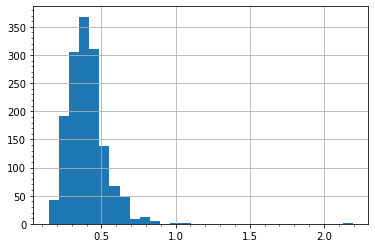

In [60]:
rate = 8000
sampel_times = [len(x)/rate for x in X]
plt.hist(sampel_times, bins = 30)
plt.grid();

17567


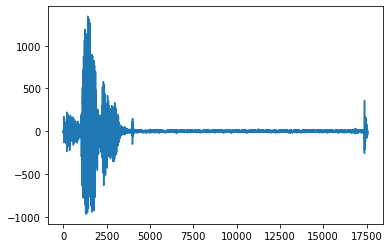

In [64]:
Longest_audio = np.argmax([len(x) for x in X])
plt.plot(X[Longest_audio]);
print(len(X[Longest_audio]))

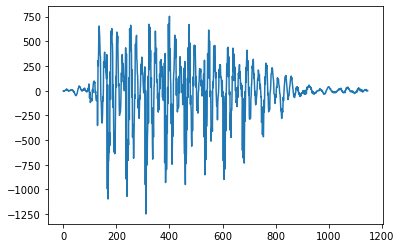

In [65]:
Shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X[Shortest_audio]);

In [47]:
N = 5000
X_uniform = []
for x in X:
    if len(x) < N:
        X_uniform.append(np.pad(x, (0, N - len(x)), constant_values = (0, 0)))
    else:
        X_uniform.append(x[:N])


In [48]:
min([len(x) for x in X_uniform])

5000

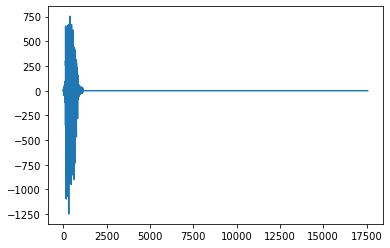

In [13]:
Shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X_uniform[Shortest_audio]);

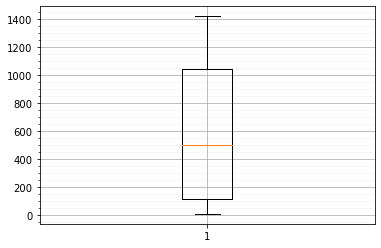

In [65]:
x_mean = np.mean(np.abs(X_uniform), axis = 0)
plt.boxplot(x_mean);
plt.grid()
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)

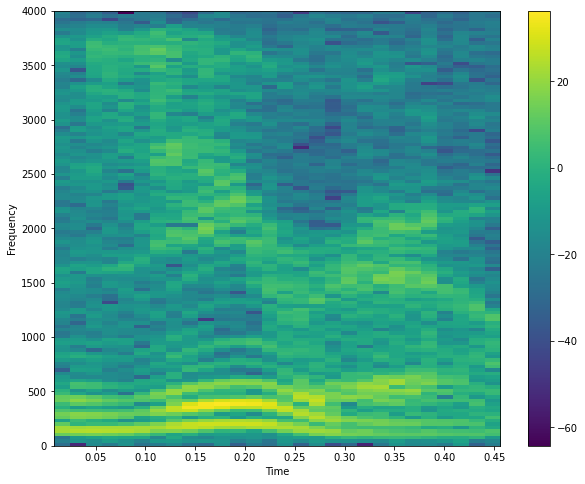

In [13]:
# Plot the spectrogram

fig, ax = plt.subplots(figsize = (10,8))

powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(X[50], Fs=8000, scale = "dB")
fig.colorbar(imageAxis)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()   

In [17]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV

In [100]:
def into_bins(X, bins = 20):
    X_mean_sd = []
    for x in X:
        x_mean_sd = []
        As = np.array_split(np.array(x), 20)
        for a in As:
            mean = np.round(a.mean(dtype=np.float64), 4)
            sd = np.round(a.std(dtype=np.float64), 4)
            x_mean_sd.extend([mean, sd])

        X_mean_sd.append(x_mean_sd)
    return np.array(X_mean_sd)

In [16]:
for bins in range(20,101,20):
    X_mean_sd = into_bins(X, bins)
    X_train, X_eval, y_train, y_eval = train_test_split(X_mean_sd, y, test_size = 0.20)
    clf = RFC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_eval)
    accuracy_score(y_eval, y_pred)
    p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
    print(f"for {bins} bins, f-macro:{f.mean()}")

for 20 bins, f-macro:0.5832986785229577
for 40 bins, f-macro:0.6245077961752795
for 60 bins, f-macro:0.6908952702906821
for 80 bins, f-macro:0.6450257899724335
for 100 bins, f-macro:0.6156417018495677


In [13]:
X_mean_sd = into_bins(X, 100)
X_train, X_eval, y_train, y_eval = train_test_split(X_mean_sd, y, test_size = 0.20)
clf = RFC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
accuracy_score(y_eval, y_pred)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

NameError: name 'into_bins' is not defined

In [18]:
param_grid = {
    "n_estimators": [100,150,200],
    "criterion": ["gini", "entropy"],
    "min_impurity_decrease": [0.0,0.05,0.1]
}

In [19]:
clf = RFC()
grid_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_impurity_decrease': [0.0, 0.05, 0.1],
                         'n_estimators': [100, 150, 200]},
             scoring='f1_macro')

In [20]:
grid_search.best_params_

{'criterion': 'entropy', 'min_impurity_decrease': 0.0, 'n_estimators': 150}

In [21]:
grid_search.best_score_

0.6039043017303212

In [22]:
eval_data = []
y_ids = []
for file in eval_files:
    label = int(file.split(".")[0])
    rate, data = wavfile.read(join(eval, file))
    eval_data.append(data.astype(np.float16))
    y_ids.append(label)
X_test = into_bins(eval_data)
y_ids = np.array(y_ids)

In [23]:
clf_gs = grid_search.best_estimator_
y_test = clf_gs.predict(X_test)

In [24]:
res = np.hstack((y_ids[:,np.newaxis], y_test[:,np.newaxis]))
res[res[:,0].argsort()][:50]

array([[ 0,  2],
       [ 1,  1],
       [ 2,  2],
       [ 3,  0],
       [ 4,  3],
       [ 5,  9],
       [ 6,  8],
       [ 7,  9],
       [ 8,  5],
       [ 9,  8],
       [10,  3],
       [11,  5],
       [12,  1],
       [13,  1],
       [14,  8],
       [15,  6],
       [16,  8],
       [17,  6],
       [18,  5],
       [19,  0],
       [20,  4],
       [21,  6],
       [22,  8],
       [23,  4],
       [24,  2],
       [25,  7],
       [26,  8],
       [27,  4],
       [28,  0],
       [29,  7],
       [30,  6],
       [31,  9],
       [32,  8],
       [33,  8],
       [34,  9],
       [35,  7],
       [36,  9],
       [37,  0],
       [38,  5],
       [39,  0],
       [40,  7],
       [41,  3],
       [42,  7],
       [43,  6],
       [44,  8],
       [45,  0],
       [46,  0],
       [47,  7],
       [48,  0],
       [49,  7]])

In [25]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [576]:
param_grid = {
    "n_neighbors": [5, 10, 15],
    "weights": ["uniform", "distance"],
    "p": [1,2]
}

In [577]:
clf = KNN()
grid_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 10, 15], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='f1_macro')

In [578]:
grid_search.best_params_, grid_search.best_score_

({'n_neighbors': 5, 'p': 1, 'weights': 'distance'}, 0.5276013059388448)

In [38]:
from sklearn import svm

In [110]:
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9575761107036108

In [15]:
from scipy.signal import spectrogram

In [67]:
def split_n_compute_mean_std(X, n):
    """Computes mean and std of each n x n block of spectrograms of X
    Parameters:
        X: 2-d sampling array
        n: number of rows or columns to split spectogram
    Returns:
        A 2-d numpy array - feature Matrix with n x n x 2 features
    """
    f_s = 8000
    X_sp = [] #feature matrix
    for x in X:
        _, _, sp = spectrogram(x, fs=f_s)
        x_sp = [] #current feature set
        for v_split in np.array_split(sp, n, axis = 0):
            for h_split in np.array_split(v_split, n, axis = 1):
                if h_split.size == 0: #happens when len(v_split[0]) < n
                    #m, sd = 0, 0
                    m = np.median(v_split).__round__(4)
                    sd = np.std(v_split).__round__(4)
                else:
                    #m = np.median(h_split).__round__(4)
                    m = np.mean(h_split).__round__(4)
                    sd = np.std(h_split).__round__(4)
                x_sp.extend([m,sd])
                
        X_sp.append(x_sp)

    return np.array(X_sp)

In [68]:
X_ft = split_n_compute_mean_std(X, 10)
len(X_ft)

1500

In [69]:
np.isnan(X_ft).sum()

0

In [70]:
X_train, X_eval, y_train, y_eval = train_test_split(X_ft, y, test_size = 0.20)
clf = RFC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
accuracy_score(y_eval, y_pred)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9501645797661864

In [33]:
param_grid = {
    "n_estimators": [50,100,150],
    "criterion": ["gini", "entropy"],
    "min_impurity_decrease": [0.0,0.01,0.2]
}

In [76]:
clf = RFC()
grid_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 3)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'criterion': 'gini', 'min_impurity_decrease': 0.0, 'n_estimators': 150},
 0.9381411729325541)

In [77]:
clf_gs = grid_search.best_estimator_
clf_gs.fit(X_train, y_train)
y_pred = clf_gs.predict(X_eval)
accuracy_score(y_eval, y_pred)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9698599240488525

In [78]:
x_test = split_n_compute_mean_std(eval_data, 10)
clf_gs = grid_search.best_estimator_
y_test = clf_gs.predict(x_test)
res = np.hstack((y_ids[:,np.newaxis], y_test[:,np.newaxis]))
res[res[:,0].argsort()][:50]

array([[ 0,  3],
       [ 1,  9],
       [ 2,  2],
       [ 3,  9],
       [ 4,  3],
       [ 5,  9],
       [ 6,  6],
       [ 7,  1],
       [ 8,  5],
       [ 9,  8],
       [10,  3],
       [11,  4],
       [12,  1],
       [13,  0],
       [14,  8],
       [15,  6],
       [16,  4],
       [17,  6],
       [18,  4],
       [19,  0],
       [20,  3],
       [21,  7],
       [22,  4],
       [23,  1],
       [24,  3],
       [25,  7],
       [26,  8],
       [27,  4],
       [28,  1],
       [29,  7],
       [30,  6],
       [31,  1],
       [32,  5],
       [33,  8],
       [34,  9],
       [35,  0],
       [36,  1],
       [37,  0],
       [38,  5],
       [39,  0],
       [40,  7],
       [41,  3],
       [42,  7],
       [43,  6],
       [44,  8],
       [45,  0],
       [46,  0],
       [47,  7],
       [48,  0],
       [49,  7]])

In [71]:
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.37337179354362987

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [40]:
steps = [('scaler', StandardScaler()), ('SVM', svm.SVC())]
pipeline = Pipeline(steps)

In [72]:
parameteres = {'SVM__C':[5,10,20], 'SVM__kernel':["linear", "poly", "rbf"]}

X_train, X_eval, y_train, y_eval = train_test_split(X_ft, y, test_size = 0.20)
grid_search = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

In [73]:
clf_gs = grid_search.best_estimator_
y_pred = clf_gs.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.8005579612610504

In [10]:
from librosa.feature import melspectrogram
from librosa import power_to_db

In [27]:
def split_n_compute_mean_std(X, n):
    """Computes mean and std of each n x n block of spectrograms of X
    Parameters:
        X: 2-d sampling array
        n: number of rows or columns to split spectogram
    Returns:
        A 2-d numpy array - feature Matrix with n x n x 2 features
    """
    f_s = 8000
    X_sp = [] #feature matrix
    for x in X:
        sp = power_to_db(melspectrogram(x, n_fft= len(x)), np.mean)
        x_sp = [] #current feature set
        for v_split in np.array_split(sp, n, axis = 0):
            for h_split in np.array_split(v_split, n, axis = 1):
                if h_split.size == 0: #happens when len(v_split[0]) < n
                    #m, sd = 0, 0
                    m = np.median(v_split).__round__(4)
                    sd = np.std(v_split).__round__(4)
                else:
                    #m = np.median(h_split).__round__(4)
                    m = np.mean(h_split).__round__(4)
                    sd = np.std(h_split).__round__(4)
                x_sp.extend([m,sd])
                
        X_sp.append(x_sp)

    return np.array(X_sp)

In [28]:
X_ft = split_n_compute_mean_std(X, 10)

In [32]:
X_train, X_eval, y_train, y_eval = train_test_split(X_ft, y, test_size = 0.20)
clf = RFC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
accuracy_score(y_eval, y_pred)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9137422899233949

In [36]:
clf = RFC()
grid_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 5)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'criterion': 'gini', 'min_impurity_decrease': 0.0, 'n_estimators': 150},
 0.9569229088129477)

In [37]:
clf_gs = grid_search.best_estimator_
y_pred = clf_gs.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9415494575026362

In [41]:
parameteres = {'SVM__C':[5,10,20], 'SVM__kernel':["linear", "poly", "rbf"], 'SVM__gamma':["scale", "auto", 0.1, 0.01]}

X_train, X_eval, y_train, y_eval = train_test_split(X_ft, y, test_size = 0.20)
grid_search = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'SVM__C': 5, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'},
 0.9766666666666666)

In [42]:
clf_gs = grid_search.best_estimator_
y_pred = clf_gs.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9681916786876401

In [43]:
import librosa

In [82]:
def remove_silence(sample, sr= 8000, top_db = 10):
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, index = librosa.effects.trim(y, top_db= top_db)
    #fig, ax = plt.subplots(1,2)
    #fig.set_size_inches(10, 6)
    #ax[0].plot(y)
    #ax[0].set_title("Orignal signal")
    #ax[1].plot(yt)
    #ax[1].set_title("Trimmed Signal")
    #plt.show()
    return yt


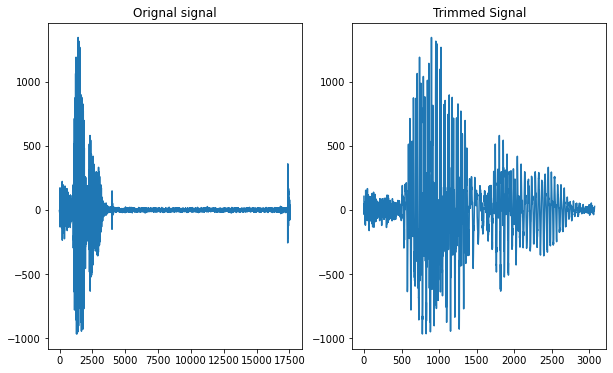

array([106., -31.,  -1., ...,  17.,  14.,  27.])

In [80]:
remove_silence(X[Longest_audio])

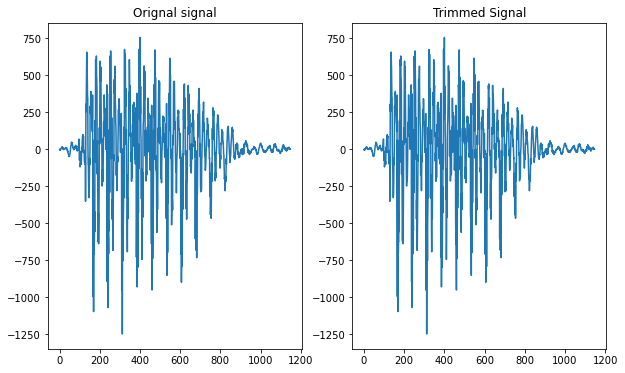

array([-2., -7., -7., ...,  3., -1.,  0.])

In [81]:
remove_silence(X[Shortest_audio])

In [83]:
X_tr = [remove_silence(x) for x in X]

In [85]:
np.argmax([len(x) for x in X_tr])

1419

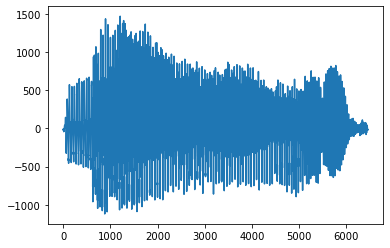

In [96]:
plt.plot(X[1419]);

In [88]:
import IPython.display as ipd

In [94]:
ipd.Audio(X[Longest_audio], rate=8000)

In [95]:
ipd.Audio(X_tr[Longest_audio], rate=8000)

In [97]:
ipd.Audio(X_tr[1419], rate=8000)

In [98]:
N = np.max([len(x) for x in X_tr]) + 1
X_tr_uniform = []
for x in X_tr:
    X_tr_uniform.append(np.pad(x, (0, N - len(x)), constant_values = (0, 0)))


In [104]:
len(y)

3124

In [107]:
X_mean_sd = into_bins(X_tr_uniform, 100)
X_train, X_eval, y_train, y_eval = train_test_split(X_mean_sd, y, test_size = 0.20)
clf = RFC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
accuracy_score(y_eval, y_pred)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.6014594951815158

In [108]:
X_tr_ft = split_n_compute_mean_std(X_tr, 10)

In [109]:
X_train, X_eval, y_train, y_eval = train_test_split(X_tr_ft, y, test_size = 0.20)
clf = RFC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)
accuracy_score(y_eval, y_pred)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.961280796355374

In [111]:
param_grid = {
    "n_estimators": [50,100,150],
    "criterion": ["gini", "entropy"],
    "min_impurity_decrease": [0.0,0.01,0.2]
}
clf = RFC()
grid_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 3)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'criterion': 'gini', 'min_impurity_decrease': 0.0, 'n_estimators': 150},
 0.9475300538018505)

In [112]:
clf_gs = grid_search.best_estimator_
y_pred = clf_gs.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9659217010705348

In [113]:
parameteres = {'SVM__C':[5,10,20], 'SVM__kernel':["linear", "poly", "rbf"], 'SVM__gamma':["scale", "auto", 0.1, 0.01]}

X_train, X_eval, y_train, y_eval = train_test_split(X_ft, y, test_size = 0.20)
grid_search = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'SVM__C': 5, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'},
 0.9741666666666667)

In [114]:
clf_gs = grid_search.best_estimator_
y_pred = clf_gs.predict(X_eval)
p,r,f,s = precision_recall_fscore_support(y_eval, y_pred)
np.mean(f)

0.9806436326831063